In [70]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Conv3D,Conv3DTranspose,Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [5]:
print(tf.__version__)
print(np.__version__)

2.2.0
1.18.4


In [41]:
# loading the dataset
with_makeup="./makeup_datset/data/gan_makeup_data_96/with"
without_makeup="./makeup_datset/data/gan_makeup_data_96/without"


In [65]:
# total no. of files in with label and without label
total_files_with=0
total_files_without=0
for i in os.listdir(with_makeup):
    total_files_with+=1
for i in os.listdir(without_makeup):
    total_files_without+=1
print(f"total makeup files > {total_files_with}")
print(f"total without makeup files > {total_files_without-2}")

total makeup files > 1089
total without makeup files > 1089


In [33]:
# loading the dataset with the labels

In [45]:
with_makeup_=[]
for i in os.listdir(with_makeup):
    with_makeup_.append(plt.imread(with_label+"/"+i))


In [46]:
print(len(with_makeup_))

1089


In [58]:
without_makeup_=[]
for i in os.listdir(without_makeup):
    try:
        without_makeup_.append(plt.imread(without_makeup+"/"+i))
    except:
        continue

In [59]:
len(without_makeup_)

1089

In [104]:
# DEFINIGN the models
# up means with makeup
# down means without makeup
# we have 3 channel layer so using that
gen_model_up_down=tf.keras.Sequential(
[
        Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=with_makeup_[0].shape,padding="same"),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        Conv2D(32,kernel_size=(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        Conv2DTranspose(32,kernel_size=(3,3),padding="same",strides=(2,2),activation="relu"),
        Conv2DTranspose(32,kernel_size=(3,3),padding="same",strides=(2,2),activation="relu"),
        tf.keras.layers.BatchNormalization(),
        Conv2DTranspose(3,kernel_size=(3,3),padding="same",strides=(2,2),activation='relu')
]

)

In [105]:
ans=gen_model_up_down.predict(with_makeup_[0].reshape(1,96,96,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


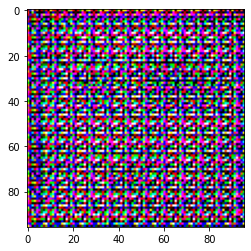

In [107]:
plt.imshow(ans.reshape(96,96,3))

In [134]:
# normalising the data
with_makeup_=np.array(with_makeup_)/255

In [ ]:
data=[]
for i in without_makeup_:
    if i.shape!=(96,96,3):
        data.append(i)
    else:
        print(i)
without_makeup_=np.array(data)/255
    

In [108]:
gen_model_down_up=tf.keras.Sequential(
[
        Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=with_makeup_[0].shape,padding="same"),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        Conv2D(32,kernel_size=(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        Conv2DTranspose(32,kernel_size=(3,3),padding="same",strides=(2,2),activation="relu"),
        Conv2DTranspose(32,kernel_size=(3,3),padding="same",strides=(2,2),activation="relu"),
        tf.keras.layers.BatchNormalization(),
        Conv2DTranspose(3,kernel_size=(3,3),padding="same",strides=(2,2),activation='relu')
]

)

In [109]:
disc_model=tf.keras.Sequential(
[
        Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=with_makeup_[0].shape,padding="same"),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        Conv2D(32,kernel_size=(3,3),padding='same'),
        tf.keras.layers.BatchNormalization(),
        Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Flatten(),
        Dense(128,activation="relu"),
        Dense(32,activation="relu"),
        Dense(1,activation='sigmoid')
]
)

In [110]:
disc_model.output_shape

(None, 1)

In [111]:
# defining losses for generators and models
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(read)-real)
    fake_loss=cross_entropy(tf.zeros_like(fake)-fake)
    return (real_loss+fake_loss)

def gen_up_down_loss(fake):
    return cross_entropy(tf.ones_like(fake),fake)

# X is the input and x is the ouput produced by the gen_down_up 
def cycle_loss(X,x):
    return tf.reduce_mean(tf.abs(X-x))


    

In [114]:
# definign the optimizers
gen_up_down_opti=tf.keras.optimizers.Adam(learning_rate=0.01)
gen_down_up_opti=tf.keras.optimizers.Adam(learning_rate=0.01)
desc_opti=tf.keras.optimizers.Adam(learning_rate=0.01)

In [130]:
# real one m with makeup, real2 without makeup
def training(real,real1):
    with tf.GradientTape() as up_down,tf.GradientTape() as desc,tf.GradientTape() as cycle:
#         first generator stuff
        fake=gen_model_up_down(real,training=True)
        disc_prediction_fake=disc_model(fake,training=True)
        disc_prediction_real=disc_model(real1,training=True)
        disc_loss_=disc_loss(real=disc_prediction_real,fake=disc_prediction_fake)
        gen_up_down_loss_=gen_up_down_loss(disc_prediction_fake)
#         second generator stuff
        gen_down_up_output=gen_model_down_up(fake,training=True)
        cycle_loss_=cycle_loss(real,gen_down_up_output)
#         optimizing and back propagating the model
        gradients_model_up_down=up_down.gradient(gen_up_down_loss_,gen_model_up_down.trainable_variables)
        gradients_descriminator=desc.gradient(disc_loss_,disc_model.trainable_variables)
        gradients_model_down_up=cycle.gradient(cycle_loss_,gen_model_down_up.trainable_variables)
#         optimizing the things
        gen_up_down_opti.apply_gradients(zip(gradients_model_up_down,gen_model_up_down.trainable_variables))
        gen_down_up_opti.apply_gradients(zip(gradients_model_down_up,gen_model_down_up.trainable_variables))
        desc_opti.apply_gradients(zip(gradients_descriminator,disc_model.trainable_variables))

        
        
        
        

In [131]:
# we already have the data in global so we will not pass the thing in this function
# saving models as checkpoints after 10 epochs 
checkpoint_loc="./checkpoints_models"
checkpoint_prefix=os.path.join(checkpoint_loc,'chkp')
checkpoint=tf.train.Checkpoint(optimizer_up_down=gen_up_down_opti,
                    optimizer_down_up=gen_down_up_opti,
                    optimizer_desc=desc_opti,
                    generator_up_down=gen_model_up_down,
                    generator_down_up=gen_model_down_up,
                    descriminator=disc_model)

    

In [132]:
# def plotting_stuff():
    

In [ ]:
def training_gan():
    epochs=5
    batch_size=181
    i=0
    for i in range(0,len(with_makeup_),batch_size):
        training(with_makeup_[i:i+33],without_makeup_[i:i+33])
    
    if (epochs+1)%10==0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
        

33.0

In [129]:
1086/181

6.0